In [414]:
import numpy as np
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

In [415]:
features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")

In [416]:
label = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

In [417]:
df = features.merge(label, on='respondent_id', how='inner')

df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [418]:
def df_summary(df):
    
    print(f"Dataset Shape: {df.shape}")
    
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    
    summary = summary.reset_index()
    
    summary['Name'] = summary['index']
    
    summary = summary[['Name','dtypes']]
    
    summary['Uniques'] = df.nunique().values
    
    summary['Missing Count'] = df.isnull().sum().values
    
    summary['Missing Percentage'] = df.isnull().sum().values/len(df)
    
    summary['Missing Percentage'] = summary['Missing Percentage'].map("{:.2%}".format)
    
    for name in summary['Name'].value_counts().index:
        
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [419]:
df_summary(df)

Dataset Shape: (26707, 37)


,Name,dtypes,Uniques,Missing Count,Missing Percentage,Entropy
0,h1n1_concern,float64,4,92,0.34%,1.86
1,h1n1_knowledge,float64,3,116,0.43%,1.33
2,behavioral_antiviral_meds,float64,2,71,0.27%,0.28
3,behavioral_avoidance,float64,2,208,0.78%,0.85
4,behavioral_face_mask,float64,2,19,0.07%,0.36
5,behavioral_wash_hands,float64,2,42,0.16%,0.67
6,behavioral_large_gatherings,float64,2,87,0.33%,0.94
7,behavioral_outside_home,float64,2,82,0.31%,0.92
8,behavioral_touch_face,float64,2,128,0.48%,0.91
9,doctor_recc_h1n1,float64,2,2160,8.09%,0.76


In [420]:
vars_with_num = [var for var in df.columns if df[var].dtype != 'O' and var not in ['h1n1_vaccine', 'seasonal_vaccine']]

df[vars_with_num].head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,0.0,0.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,1.0,0.0


In [421]:
vars_with_cat = [var for var in df.columns if df[var].dtype == 'O']

df[vars_with_cat].head()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,NaN,NaN
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",NaN,NaN
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb


In [422]:
X_num_cols = [var for var in df.columns if df[var].dtype != 'O' and var not in ['h1n1_vaccine', 'seasonal_vaccine']]
X_num = df[X_num_cols]

In [423]:
X_cat_cols = [var for var in df.columns if df[var].dtype == 'O' and var not in ['h1n1_vaccine', 'seasonal_vaccine']]
X_cat = df[X_cat_cols]

In [424]:
X_cols = [var for var in df.columns if var not in ['h1n1_vaccine', 'seasonal_vaccine']]
X = df[X_cols]

In [425]:
y_cols = ['h1n1_vaccine', 'seasonal_vaccine']
y = df[y_cols]

In [426]:
# Categorical features

In [427]:
imp_constant = SimpleImputer(strategy='constant', fill_value='missing')
ohe = OneHotEncoder()

In [428]:
imp_ohe = make_pipeline(imp_constant, ohe)

In [429]:
# Numeric features

In [430]:
imp = SimpleImputer(strategy='median')

In [431]:
ct = make_column_transformer(
    (imp_ohe, X_cat_cols),
    (imp, X_num_cols),
    remainder='passthrough')
ct

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('pipeline',
                                 Pipeline(memory=None,
                                          steps=[('simpleimputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value='missing',
                                                                missing_values=nan,
                                                                strategy='constant',
                                                                verbose=0)),
                                                 ('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=

In [432]:
estimator = LogisticRegression(penalty="l2", C=1, max_iter=1000, random_state=123)

In [433]:
estimators = MultiOutputClassifier(estimator)

In [434]:
pipe = make_pipeline(ct, estimators)

In [435]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    shuffle=True,
    stratify=y,
    random_state=123
)

In [436]:
pipe.fit(X_train, y_train)

# Predict on test set
# This competition wants probabilities, not labels
preds = pipe.predict_proba(X_test)
preds

[array([[0.96251155, 0.03748845],
        [0.95714064, 0.04285936],
        [0.38342799, 0.61657201],
        ...,
        [0.27303136, 0.72696864],
        [0.36070276, 0.63929724],
        [0.82935375, 0.17064625]]),
 array([[0.17524247, 0.82475753],
        [0.47607533, 0.52392467],
        [0.12485066, 0.87514934],
        ...,
        [0.09847097, 0.90152903],
        [0.09593554, 0.90406446],
        [0.18163517, 0.81836483]])]

In [437]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (8814, 2)
test_probas[1].shape (8814, 2)


In [438]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_test.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
8756,0.037488,0.824758
14356,0.042859,0.523925
7355,0.616572,0.875149
15794,0.485274,0.796824
19111,0.217061,0.765842


In [439]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

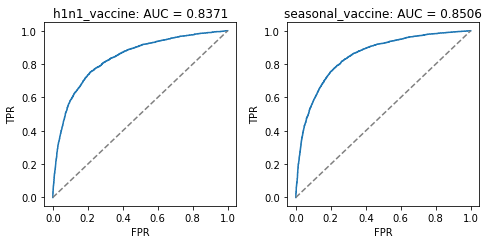

In [440]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [441]:
roc_auc_score(y_test, y_preds)

0.8438653689705884

In [442]:
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                               

In [443]:
test_features_df = pd.read_csv('data/test_set_features.csv', index_col="respondent_id")

In [444]:
test_probas = pipe.predict_proba(test_features_df)
test_probas

[array([[0.94267771, 0.05732229],
        [0.95251108, 0.04748892],
        [0.58394094, 0.41605906],
        ...,
        [0.8644167 , 0.1355833 ],
        [0.94109071, 0.05890929],
        [0.53012044, 0.46987956]]),
 array([[0.7043873 , 0.2956127 ],
        [0.95440668, 0.04559332],
        [0.40697931, 0.59302069],
        ...,
        [0.79960069, 0.20039931],
        [0.63823488, 0.36176512],
        [0.56344497, 0.43655503]])]

In [445]:
submission_df = pd.read_csv('data/submission_format.csv', index_col="respondent_id")

In [446]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [447]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.057322,0.295613
26708,0.047489,0.045593
26709,0.416059,0.593021
26710,0.486212,0.877670
26711,0.157258,0.473481


In [448]:
submission_df.to_csv('my_submission.csv', index=True)